# Basic Imports

In [1]:
import os
import random 
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from tqdm import tqdm
import time
import pandas as pd
import joypy
from collections import defaultdict
from scipy.stats import gaussian_kde
import imageio
import torchvision.transforms as transforms
from lpips import LPIPS
import warnings
warnings.filterwarnings("ignore")

# code reproducablity...
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
print("Torch version : ",torch.__version__)

Torch version :  2.3.0


# Pipeline Constants

In [177]:
grid_size = (200,200) # w,h format since we are using PIL library...
train_epochs = 5000
learning_rate = 30
target_dimensions = (3000,1000) # trying to keep similar aspect ratio as the original input image...

# Loading Test Images....

Image dimensions : W = 1440 | H = 849


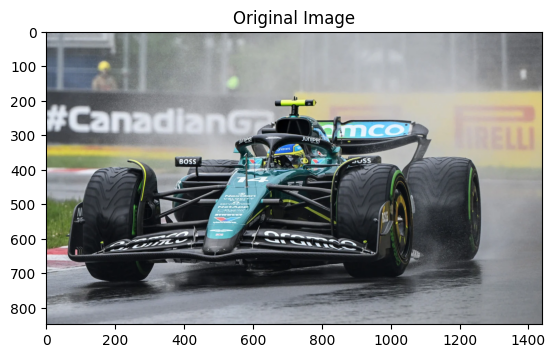

In [227]:
img = Image.open("./aston.jpg")
og_dimensions = img.size
print("Image dimensions : W = {} | H = {}".format(img.size[0], img.size[1]))
plt.imshow(img, cmap = "gray")
plt.title("Original Image")
plt.show()

# Resizing the image to grid dimensions for comparison to ReluFields

Image dimensions : W = 200 | H = 200


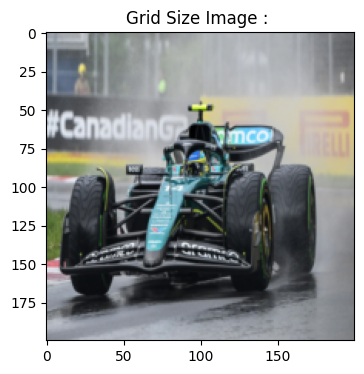

In [228]:
base_img = img.resize(grid_size,  Image.BILINEAR)
plt.figure(figsize = (4,4))
plt.imshow(base_img, cmap = "gray")
print("Image dimensions : W = {} | H = {}".format(base_img.size[0], base_img.size[1]))
plt.title("Grid Size Image : ")
plt.show()

# ReLU Field Pipeline

In [229]:
class reluField(nn.Module):
    def __init__(self, gs, feat_dim = 1, gt_dim = (100,100)):
        
        super().__init__()
        # tuple....
        self.grid_size = gs
        self.feat_dim = feat_dim

        # gt shape to help figure out the 
        self.gt_dim = gt_dim
        # random initialization of grid feature values....
        self.rand_grid = nn.Parameter(torch.rand((1,  self.feat_dim, self.grid_size[0], self.grid_size[1])))
        
        
    def forward(self, img):
        upsampled_grid = torch.nn.functional.interpolate(self.rand_grid, size = img.shape[2:], mode = 'bilinear')
        return torch.clip(torch.nn.ReLU()(upsampled_grid), max = 1.0)

# Train ReLU Fields...

In [230]:
# instantiating the model....
rModel = reluField(gs = grid_size, feat_dim = 3)
optimizer_ft = optim.SGD(rModel.parameters(), lr = learning_rate)
loss = nn.L1Loss()

# progress bar...
pbar = tqdm(range(train_epochs), total = train_epochs)

# Loading & normalizing the original image as target for the loss function....
target_img = torchvision.transforms.functional.pil_to_tensor(img).unsqueeze(0)
target_img = target_img/255

# placeholder variables...
epoch_ctr = 0
gradient_dict = {'Epoch': [], 'Gradient': []}

intermediate_results = []
grad_save_lim = 100

for i in pbar:  
    # moving tensors to gpu....
    inputs = target_img.to('cpu')

    # zero the parameter gradients
    optimizer_ft.zero_grad()
    with torch.set_grad_enabled(True):
        outputs  = rModel(inputs)
        loss_val = loss(outputs, inputs)

    string = "loss value : {:.3f}".format(loss_val.detach().cpu().numpy())
    pbar.set_description(string)
        
    # applying computed gradients....
    loss_val.backward()
    optimizer_ft.step()    

     # saving gradients 
    if epoch_ctr%grad_save_lim==0:
        intermediate_grads = []
        for paramV in rModel.parameters():
            intermediate_grads.append(torch.flatten(paramV.grad.data).cpu().numpy())

        gradient_dict['Epoch'].extend([epoch_ctr] * len(intermediate_grads))
        gradient_dict['Gradient'].extend(intermediate_grads)

    # inference...
    if epoch_ctr%500 == 0:
        with torch.set_grad_enabled(False):
            op = rModel(img = torch.rand((1,1,og_dimensions[1],og_dimensions[0])))
            res_img = torchvision.transforms.functional.to_pil_image(op[0], mode=None)
            intermediate_results.append(res_img)

    epoch_ctr+=1

loss value : 0.022: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:41<00:00, 49.46it/s]


# ReLU field Inference 

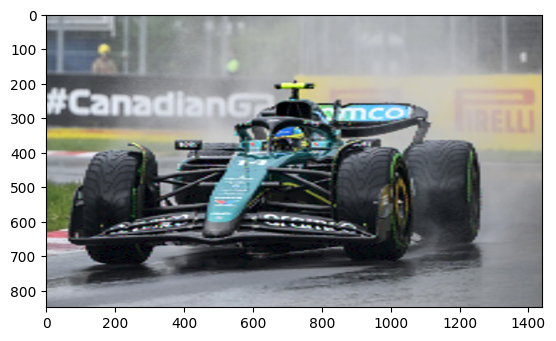

In [231]:
op = rModel(img = torch.rand((1,3,og_dimensions[1],og_dimensions[0])))
res_img = torchvision.transforms.functional.to_pil_image(op[0], mode=None)
save_dir = os.path.join(os.getcwd(), "reluField_results")
plt.imsave(os.path.join(save_dir, "pyTorch_reluField.jpg"), res_img, cmap='gray')
plt.imshow(res_img, cmap ="gray")

# Progress across Epochs

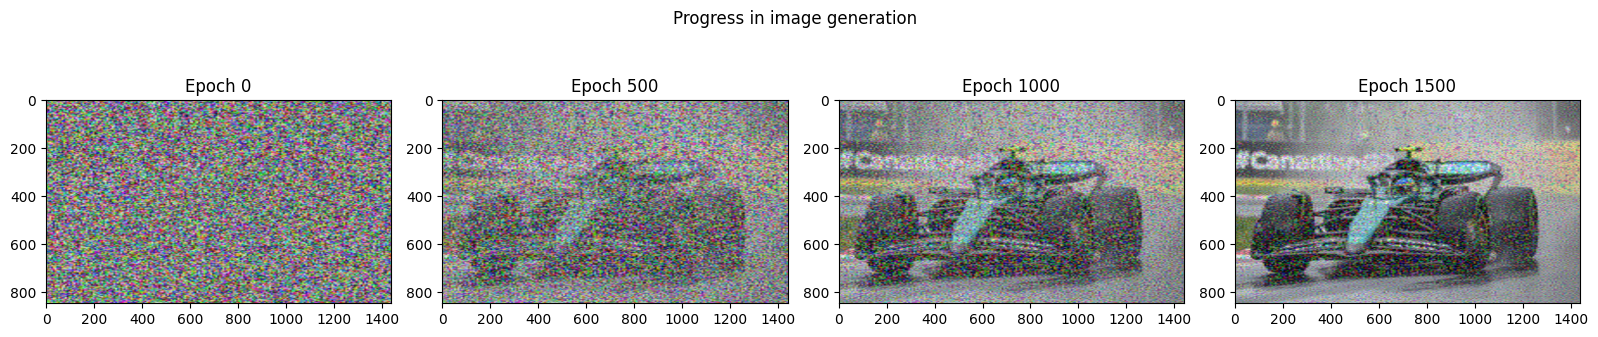

In [232]:
# Create a figure with a row of 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Display each image in its own subplot
axes[0].imshow(intermediate_results[0], cmap='gray')
axes[0].set_title('Epoch 0')

axes[1].imshow(intermediate_results[1], cmap='gray')
axes[1].set_title('Epoch 500')

axes[2].imshow(intermediate_results[2], cmap='gray')
axes[2].set_title('Epoch 1000')

axes[3].imshow(intermediate_results[3], cmap='gray')
axes[3].set_title('Epoch 1500')

# Adjust the layout
plt.tight_layout()
plt.suptitle("Progress in image generation")

plt.savefig(os.path.join(save_dir,"training_progress.jpg"), format='jpg', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

# Comparison against image resize from regular gird

In [233]:
resized_base_img = base_img.resize(og_dimensions,  Image.BILINEAR)
plt.imsave(os.path.join(save_dir, "resized_image_bilinear_{}_{}_grid_{}_{}.jpg".format(og_dimensions[0],og_dimensions[1], grid_size[0], grid_size[1])),
                resized_base_img,)
                #cmap = "gray")

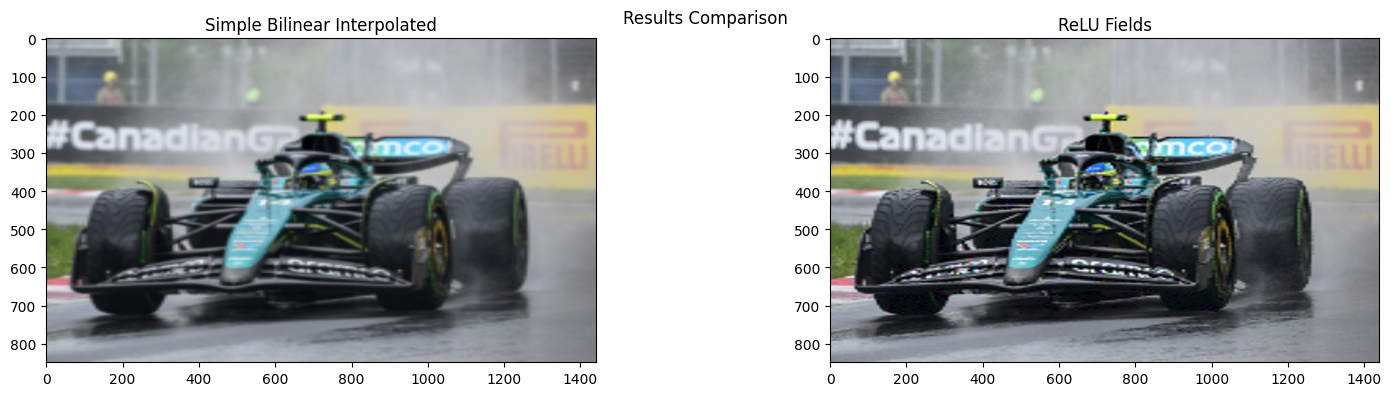

In [236]:
resized_base_img = base_img.resize(og_dimensions,  Image.BILINEAR)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Display each image in its own subplot
axes[0].imshow(resized_base_img,  cmap = "gray")
axes[0].set_title('Simple Bilinear Interpolated')

axes[1].imshow(res_img,  cmap = "gray")
axes[1].set_title('ReLU Fields')
plt.tight_layout()
plt.suptitle("Results Comparison")

plt.savefig(os.path.join(save_dir,"rgb_loma.jpg"), format='jpg', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

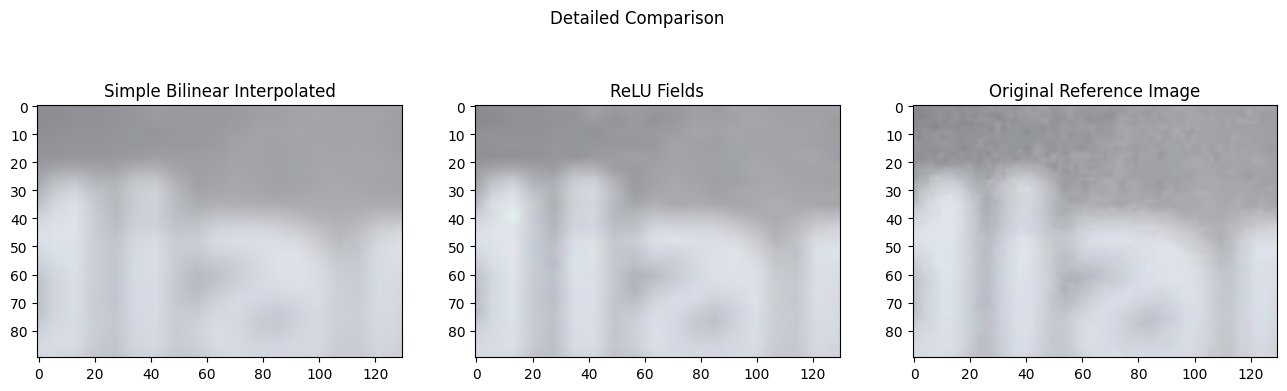

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
crop_area = (350,200,480,290)

# Display each image in its own subplot
axes[0].imshow(resized_base_img.crop(crop_area), cmap='gray')
axes[0].set_title('Simple Bilinear Interpolated')

axes[1].imshow(res_img.crop(crop_area), cmap='gray')
axes[1].set_title('ReLU Fields')

axes[2].imshow(img.crop(crop_area), cmap='gray')
axes[2].set_title('Original Reference Image')

plt.suptitle("Detailed Comparison", y=1.05)

# Show the plot
plt.show()

# Gradient Visualisation

<Figure size 1200x800 with 0 Axes>

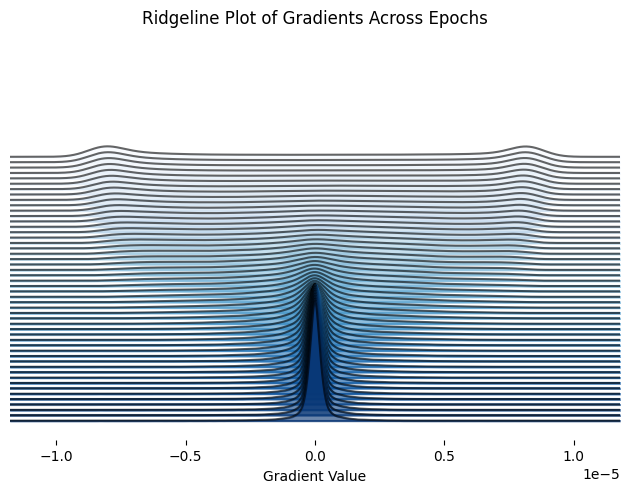

In [238]:
np.random.seed(0)
num_epochs = 10
num_gradients = 100
gradient_arrays_per_epoch = []
for i in range(len(gradient_dict['Epoch'])):
    gradient_arrays_per_epoch.append(gradient_dict['Gradient'][i])
    
# Plotting ridgeline plot
plt.figure(figsize=(12, 8))
joypy.joyplot(gradient_arrays_per_epoch, linewidth=1.5, overlap=2.0, colormap=plt.cm.Blues, alpha=0.6)

# Adjusting labels and title
plt.xlabel('Gradient Value')
plt.ylabel('Epoch')
plt.title('Ridgeline Plot of Gradients Across Epochs')

plt.savefig(os.path.join(save_dir,"pytorch_grad_plot_2.jpg"), format='jpg', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Image quality Metrics

In [239]:
def psnr(img1_path, img2_path):
    # Load images
    img1 = imageio.imread(img1_path).astype(np.float32)
    img2 = imageio.imread(img2_path).astype(np.float32)

    # Check if images are of same shape
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions")

    # Calculate MSE (Mean Squared Error)
    mse = np.mean((img1 - img2) ** 2)

    # If MSE is zero, PSNR is infinity (perfect similarity)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

def lpips_similarity(img1_path, img2_path):
    # Load images
    img1 = transforms.ToTensor()(Image.open(img1_path).convert('RGB')).unsqueeze(0)
    img2 = transforms.ToTensor()(Image.open(img2_path).convert('RGB')).unsqueeze(0)

    # Initialize LPIPS model
    lpips_model = LPIPS(net='vgg')

    # Compute LPIPS distance
    distance = lpips_model(img1, img2)

    return distance.item()

In [240]:
curr_dir = os.getcwd()
og_img_path = os.path.join(curr_dir,"aston.jpg")
test_img_path = os.path.join(save_dir, "pyTorch_reluField.jpg")
print("PSNR value is {:.4f} dB".format(psnr(img1_path = og_img_path,
                                            img2_path = test_img_path)))

print("LPIPS similarity is {:.4f}".format(lpips_similarity(img1_path = og_img_path,
                                                           img2_path = test_img_path)))

PSNR value is 9.5818 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/homebrew/Caskroom/miniforge/base/envs/diff_p/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS similarity is 0.7398


# LOMA Plots

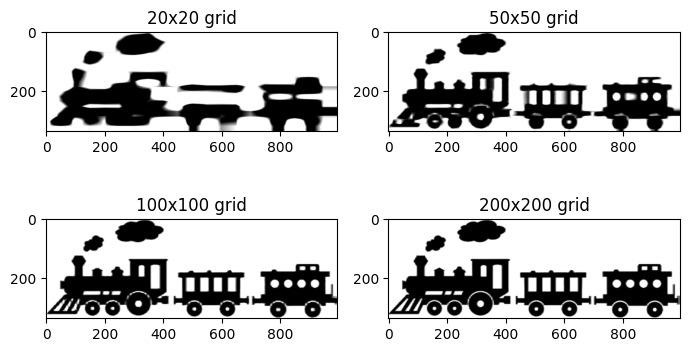

In [225]:
fig, axs = plt.subplots(2, 2, figsize=(7, 4))

img1 = Image.open(os.path.join("./reluField_results/test_images/test_RelU_fields_interpolated_image_1900_gridSize_20_20.jpg")).convert('L')
img2 = Image.open(os.path.join("./reluField_results/test_images/test_RelU_fields_interpolated_image_1900_gridSize_50_50.jpg")).convert('L')
img3 = Image.open(os.path.join("./reluField_results/test_images/test_RelU_fields_interpolated_image_1900_gridSize_100_100.jpg")).convert('L')
img4 = Image.open(os.path.join("./reluField_results/test_images/test_RelU_fields_interpolated_image_1900_gridSize_200_200.jpg")).convert('L')



# Plot data on each subplot
axs[0, 0].imshow(img1, cmap = "gray")
axs[0, 0].set_title('20x20 grid')
axs[0, 1].imshow(img2, cmap = "gray")
axs[0, 1].set_title('50x50 grid')
axs[1, 0].imshow(img3, cmap = "gray")
axs[1, 0].set_title('100x100 grid')
axs[1, 1].imshow(img4, cmap = "gray")
axs[1, 1].set_title('200x200 grid')
plt.tight_layout()


plt.savefig(os.path.join(save_dir,"diff_grid_values_LOMA.jpg"), format='jpg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Visualising feature grids

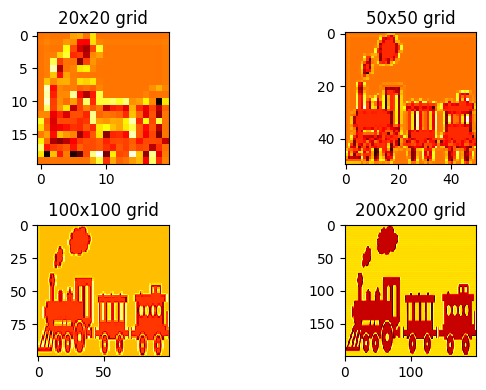

In [226]:
p1 = "./reluField_results/reluFeatureField_gs_20_20.npy"
# loading saved feature field...
with open(p1, 'rb') as f:
    g1 = np.load(f)
    
p2 = "./reluField_results/reluFeatureField_gs_50_50.npy"
# loading saved feature field...
with open(p2, 'rb') as f:
    g2 = np.load(f)
    
p3 = "./reluField_results/reluFeatureField_gs_100_100.npy"
# loading saved feature field...
with open(p3, 'rb') as f:
    g3 = np.load(f)
    
p4 = "./reluField_results/reluFeatureField_gs_200_200.npy"
# loading saved feature field...
with open(p4, 'rb') as f:
    g4 = np.load(f)

fig, axs = plt.subplots(2, 2, figsize=(7, 4))
# Plot data on each subplot
axs[0, 0].imshow(g1, cmap = "hot",  interpolation = "nearest")
axs[0, 0].set_title('20x20 grid')
axs[0, 1].imshow(g2, cmap = "hot",  interpolation = "nearest")
axs[0, 1].set_title('50x50 grid')
axs[1, 0].imshow(g3, cmap = "hot",  interpolation = "nearest")
axs[1, 0].set_title('100x100 grid')
axs[1, 1].imshow(g4, cmap = "hot",  interpolation = "nearest")
axs[1, 1].set_title('200x200 grid')
plt.tight_layout()


plt.savefig(os.path.join(save_dir,"learnt_feature_grid_values_LOMA.jpg"), format='jpg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()